# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from LDMIBSS import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "Nonnegative_Antisparse_Copula"

# Source Generation and Mixing Scenario

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 14.968816439169895


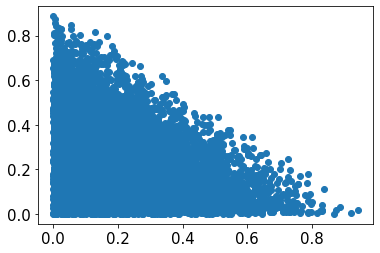

In [2]:
N = 10000
NumberofSources = 5
NumberofMixtures = 10

S = np.random.exponential(scale=1.0, size=(NumberofSources, int(N)))
S = S / np.sum(S, axis=0)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))
plt.scatter(S[0, :], S[1, :])

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.uniform(-2,2, (NumberofMixtures,NumberofSources))
X = np.dot(A, S)

SNR = 15
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

# Visualize Generated Sources and Mixtures

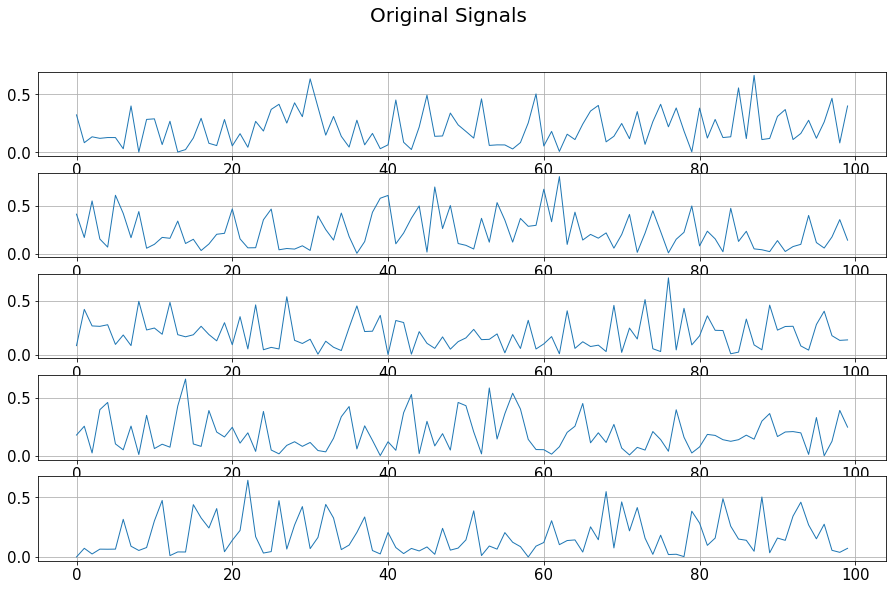

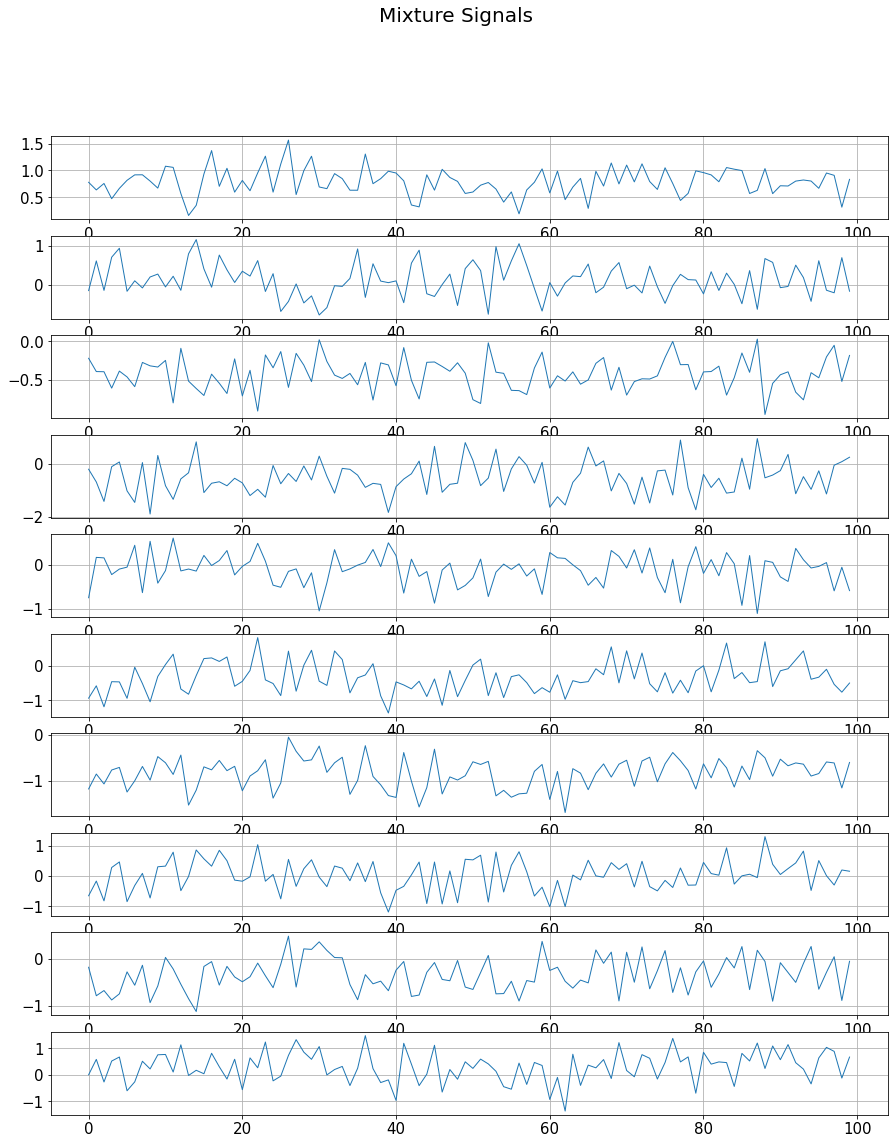

In [3]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 1000
model = LDMIBSS(s_dim=s_dim, x_dim=x_dim, set_ground_truth=True, S=S, A=A)

# Run LDMI Algorithm on Mixture Signals

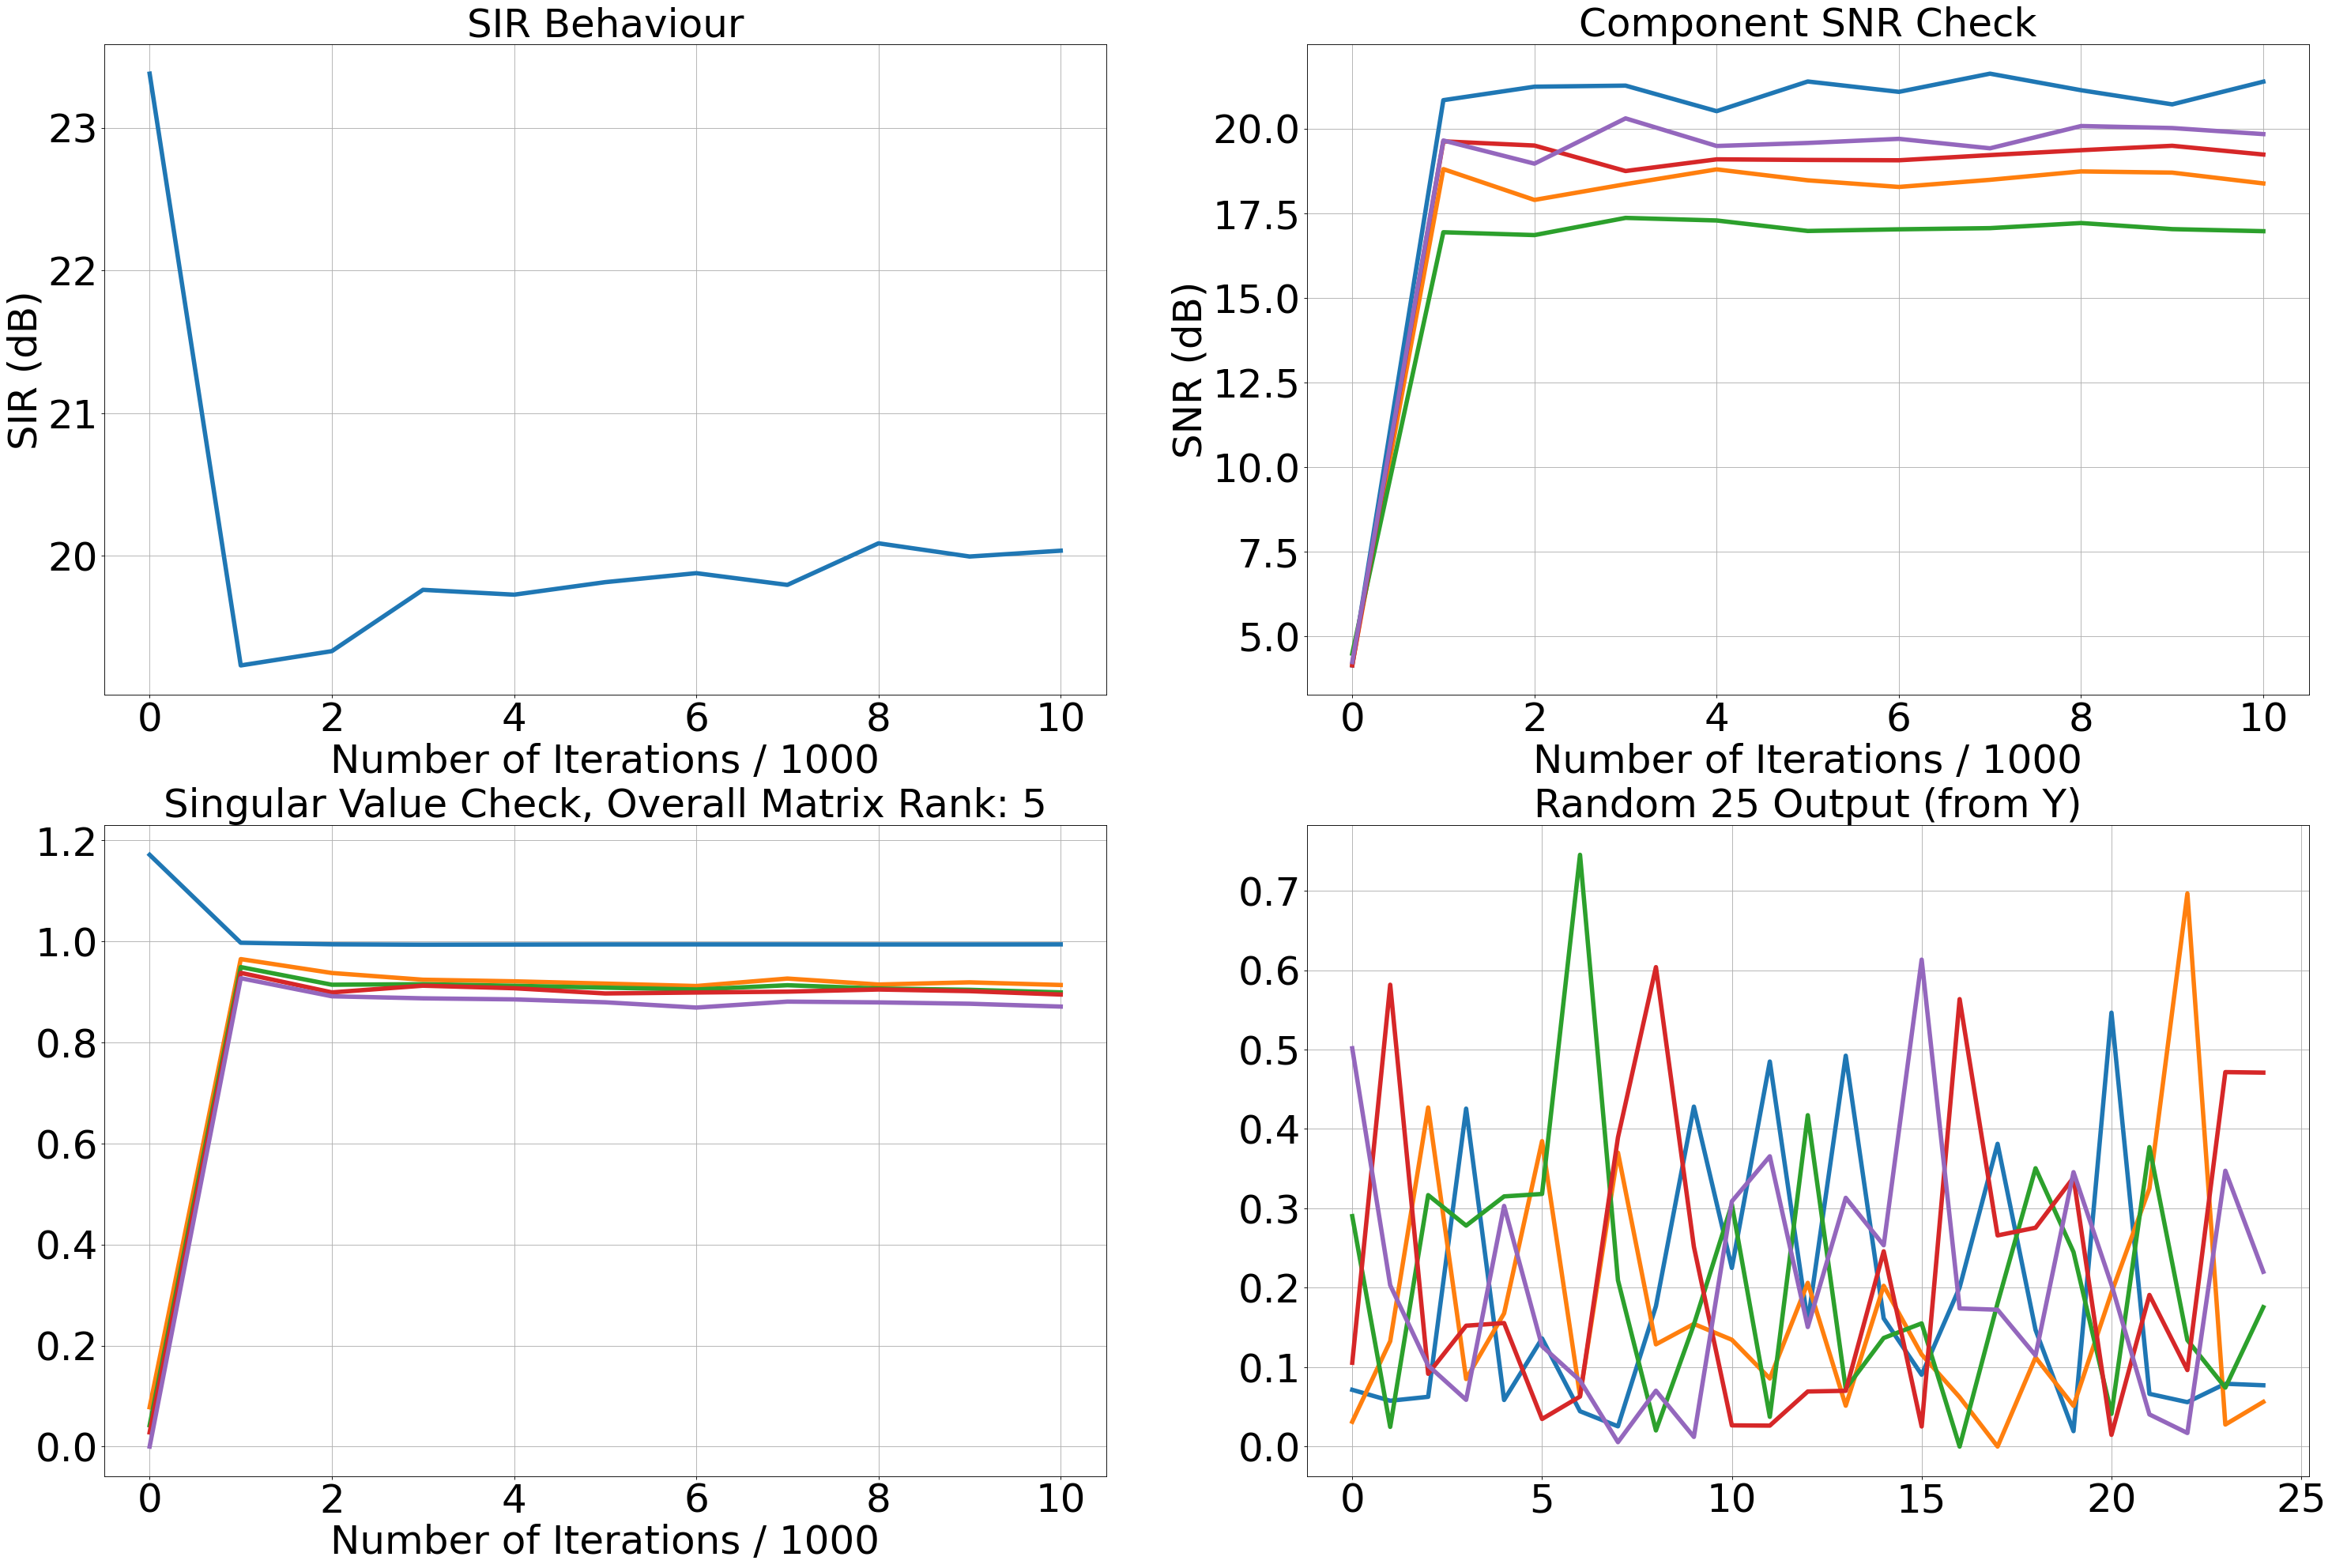

100%|██████████| 10000/10000 [01:19<00:00, 125.59it/s]


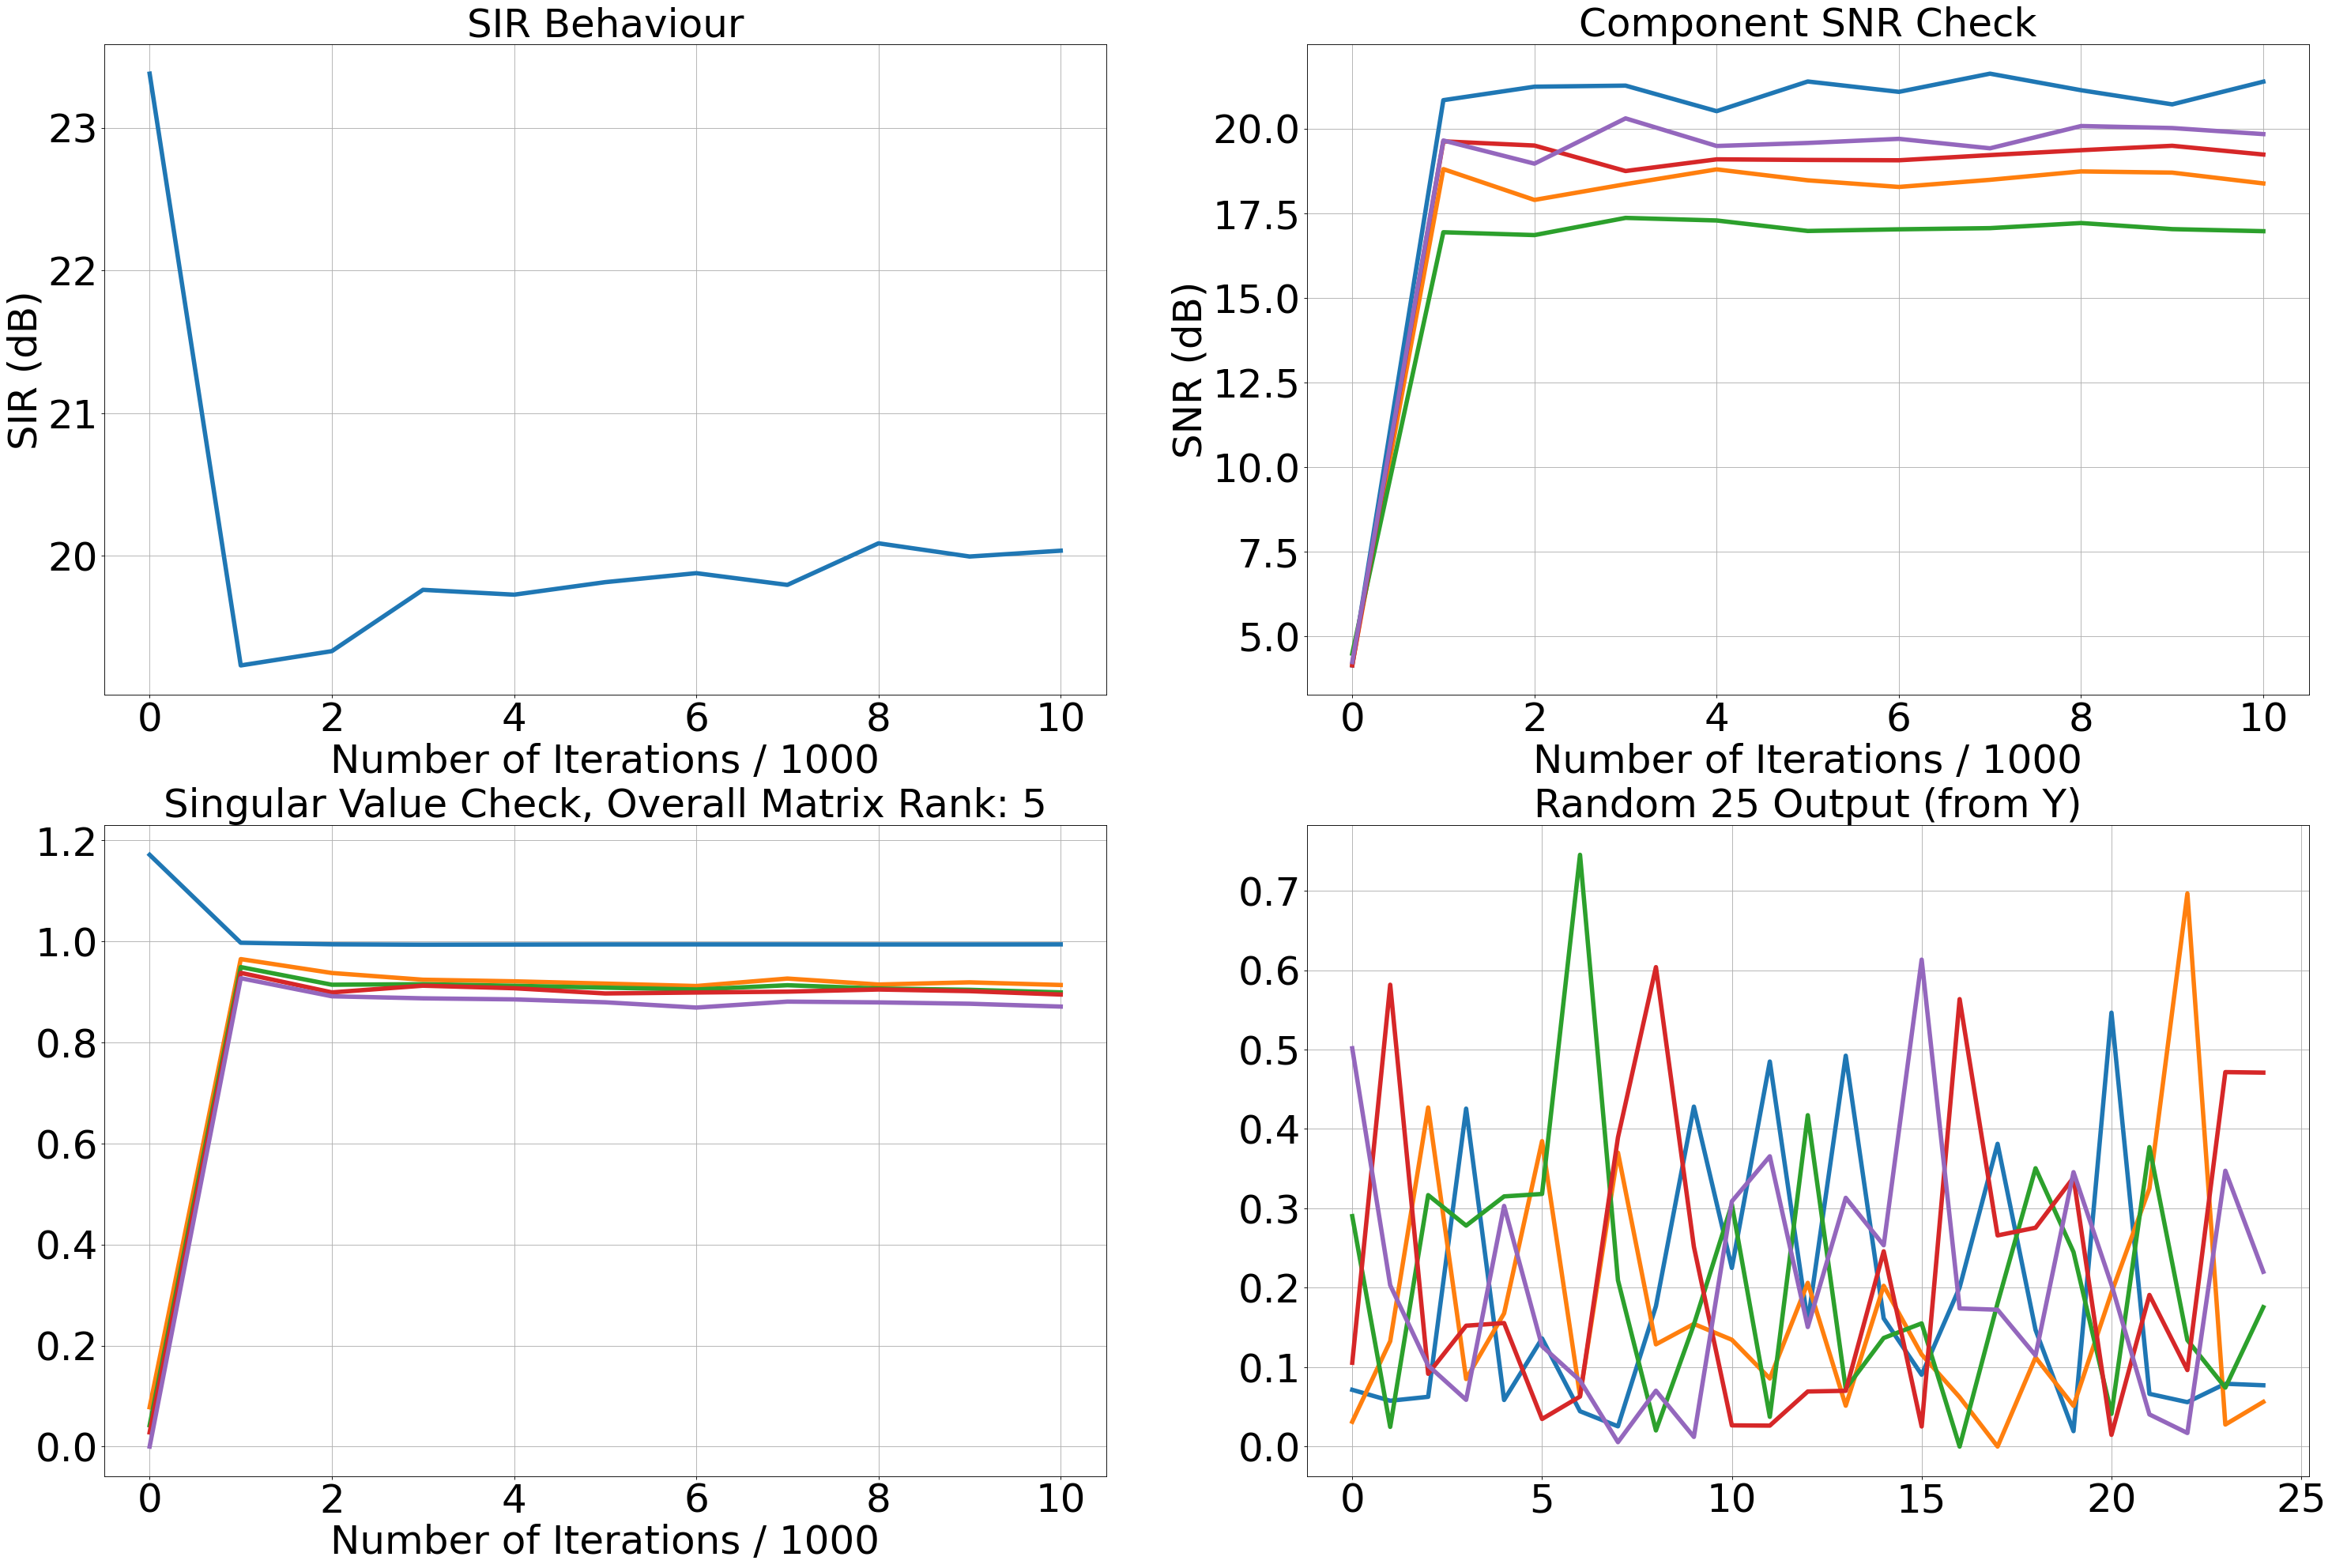

In [5]:
model.fit_batch_simplex(
    X,
    epsilon=1e-5,
    mu_start=100,
    n_iterations=10000,
    method="covariance",
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Calculate Resulting Component SNRs and Overall SINR

In [11]:
Wf = model.W
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [17.88363825 16.9423358  16.73195647 17.98344166 17.90569132]

Overall SINR : 18.07095528919094


In [7]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.W
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean,Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, Szeromean, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [13.900943   13.16885511 13.29962224 14.23115546 14.04231712]

Overall SINR : 13.516367385275617


In [13]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.W
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
perm = find_permutation_between_source_and_estimation(Szeromean,Yzeromean)
Y_ = Y_[perm,:]
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, S, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [17.88363825 16.9423358  16.73195647 17.98344166 17.90569132]

Overall SINR : 18.07095528919094


# Vizualize Extracted Signals Compared to Original Sources

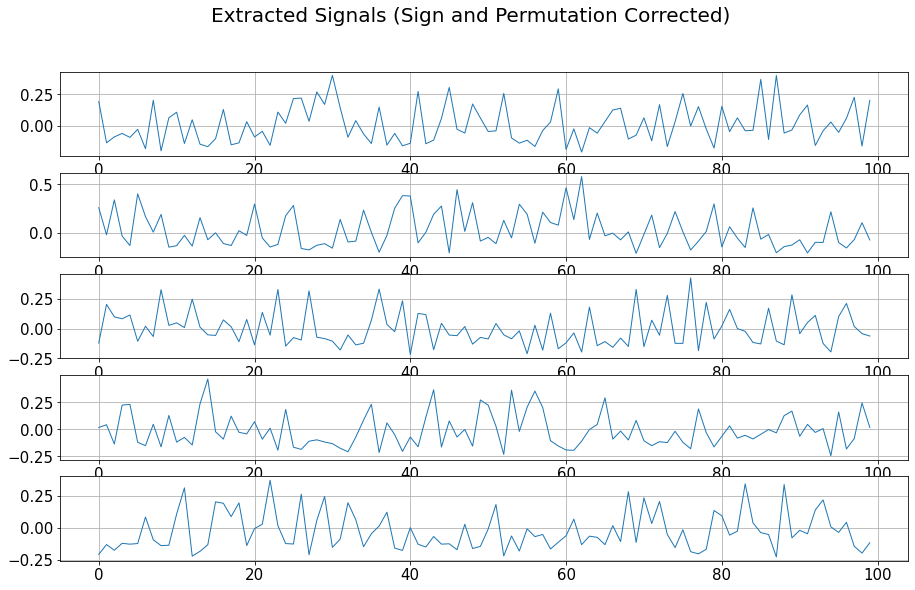

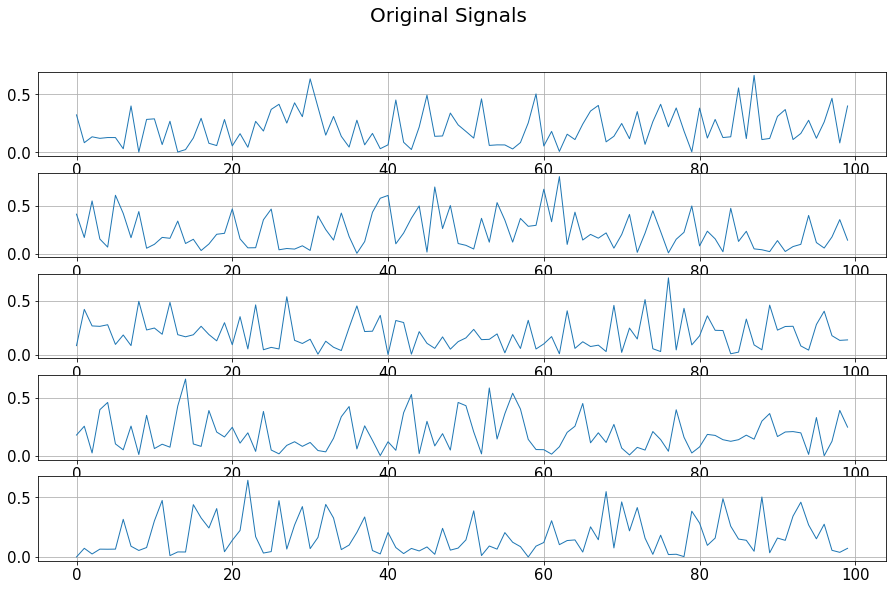

In [8]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)

In [9]:
import mir_eval

In [12]:
mir_eval.separation.bss_eval_sources(S, Y_,
                     compute_permutation=True)

(array([18.27446764, 17.73486089, 18.1290586 , 18.83195922, 18.48920415]),
 array([25.3030415 , 24.50837845, 25.03001685, 25.61008694, 25.65415206]),
 array([19.24669256, 18.77508342, 19.13424806, 19.86752042, 19.4273726 ]),
 array([0, 1, 2, 3, 4]))